In [81]:
# setup library imports
import io, time, json
import requests
from bs4 import BeautifulSoup
import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import re

# import yelp client library
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator


In [2]:
def authenticate(config_filepath):
    """
    Create an authenticated yelp-python client.

    Args:
        config_filepath (string): relative path (from this file) to a file with your Yelp credentials

    Returns:
        client (yelp.client.Client): authenticated instance of a yelp.Client
    """
    
    creds = json.load(open(config_filepath))
    auth = Oauth1Authenticator(**creds)
    return Client(auth)

In [3]:
def yelp_search(client, query):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search term

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the query
        businesses (list): list of yelp.obj.business.Business objects
    """
    
    # Write solution here
    res = client.search(query)
    return (res.total, res.businesses)

In [4]:
def all_restaurants(client, query, food):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of yelp.obj.business.Business objects
    """
    B = []
    while 1:
        try:
            res = client.search(query,**{"category_filter":food,"offset" : len(B)})
            if not res.businesses:
                return B
            B += res.businesses
#            time.sleep(.1)
        except:
            return B

In [102]:
def get_cities_info(client, food, cities):
    d = {}
    for city in cities:
        print "requesting: ", city,
        d["%s_%s"%(city,food)] = all_restaurants(client,city,food)
        print ": done"
    #d = {("%s_%s"%(city,food)):all_restaurants(client,city,food) for city in cities}
    valids = filter(lambda x: len(d[x]) >= 10, d)
    res = {v:d[v] for v in valids}
    return res

def get_all_cities():
    with open("cities.txt",'r') as f:
        lines = map(lambda l: ", ".join(l.rstrip().split("\t")[1:3]),f.readlines())
        return lines
    
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
def save_pickle(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
        
def get_city_data(data, city, foodtype):
    '''returns dictionary:
        avg_review
        num_restaurants
        city
    '''
    result = {}
    key = "%s_%s"%(city,foodtype)
    info = data[key]
    result["num_restaurants"] = len(info)
    result["avg_review"] = sum(map(lambda x: x.rating, info))/float(len(info))
    return result
    
def get_all_city_data(data):
    result = {}
    for city_food in data:
        city = city_food.split("_")[0]
        foodtype = city_food.split("_")[1]
        result[city] = get_city_data(data,city,foodtype)
    return result

def clean_business(b):
    valids = ["categories", "location", "name", "rating", "review_count","url"]
    return {x : b.__dict__[x] for x in valids}
    
    
def clean_data(data):
    new_data = {}
    for city in data:
        new_data[city] = map(clean_business, data[city])
    return new_data

def add_feature_info(data, offset):
    c = offset+1
    for d in data[offset:]:
        print "%d of %d"%(c,len(data))
        features = scrapeYelpFeatures(d["url"])
        d.update(features)
        c += 1
        
def get_feature_set(datalist):
    features = set()
    for f in datalist:
        features |= set(f)
    return features

def fix_features(datalist):
    features = get_feature_set(datalist)
    for d in datalist:
        for f in features:
            if f not in d:
                d[f] = None


In [95]:
def retrieve_html(url):
    html = requests.get(url)
    return (html.status_code, html.content)

# Gets restaurant features from yelp html given a url for a restaurants page
# returns a dictionary of the available features on the page (keys) with their 
# corresponding values
def scrapeYelpFeatures(url):
    (yolo, html) = retrieve_html(url)
    
    try:
        imgs =  re.search(r"See all [0-9]+", html).group()
        imgs = [int(s) for s in imgs.split() if s.isdigit()][0]
    except:
        imgs = 0
    root = BeautifulSoup(html, "html.parser")
    s = root.findAll("div", {'class' : 'ywidget'}) #, { "class" : "review review--with-sidebar" })
    #s = root.find("h3", {'name': 'More business info'})
    
    biz_features = {"number_of_images" : imgs}
    for i in s:
        h3_elem = i.find("h3")
        if h3_elem != None:
            if 'More business info' in h3_elem:
                biz_attr = i.find('ul', {'class' : 'ylist'}).findAll('dt', {'class' : 'attribute-key'})
                biz_val = i.find('ul', {'class' : 'ylist'}).findAll('dd')

                for (l,r) in zip(biz_attr, biz_val):
                    #print l.next_element.strip(), '====', r.next_element.strip()
                    biz_features[l.next_element.strip()] = r.next_element.strip()
    return biz_features

[  2.14136645e-04   3.57854820e+00]


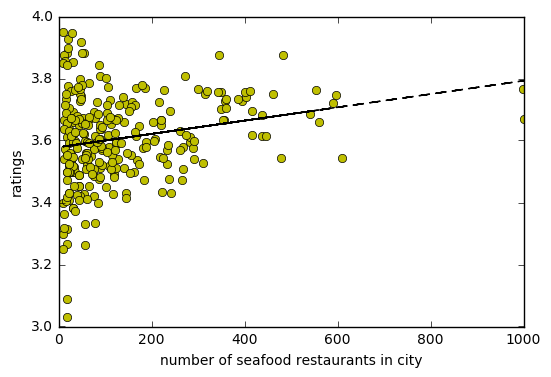

In [6]:
seafood_data = load_pickle("cities_seafood.pkl")

review_data = get_all_city_data(seafood_data)
x = map(lambda z: review_data[z]["num_restaurants"], review_data)
y = map(lambda z: review_data[z]["avg_review"], review_data)
fit = np.polyfit(x,y,1)
print fit
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.ylabel('ratings')
plt.xlabel("number of seafood restaurants in city")
plt.show()

In [ ]:
sorted_cities = sorted(list(review_data), key = lambda z: -review_data[z]["avg_review"])
for city in sorted_cities:
    print city, review_data[city]["avg_review"], review_data[city]["num_restaurants"]

In [ ]:
#save_pickle("cities_all_restaurants.pkl", get_cities_info(client, 'restaurants', get_all_cities()))

In [23]:
info = load_pickle("cities_all_restaurants_new.pkl")

In [ ]:
client = authenticate("config_secret.json")

In [98]:
#datalist = data['Anaheim, California'][:]
#print datalist[999]
#add_feature_info(datalist,268)
#save_pickle("Anaheim, California features.pkl", datalist)

In [104]:
save_pickle("Anaheim, California features.pkl", datalist)